In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [60]:
train_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/train/train"
validation_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/validation/validation"
test_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test"

creating data generators

In [61]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [62]:
df = pd.read_csv("/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
None_of_the_Above        81
1400Ripples              81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

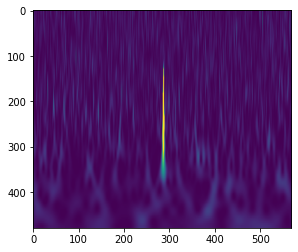

In [63]:
fullpath = train_dir + "/Blip/" + os.listdir(train_dir + "/Blip")[0]
img = mpimg.imread(fullpath)
plt.imshow(img)

getting the class names

In [64]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)
classes_list

['Blip',
 'Koi_Fish',
 'Low_Frequency_Burst',
 'Light_Modulation',
 'Power_Line',
 'Extremely_Loud',
 'Low_Frequency_Lines',
 'Scattered_Light',
 'Violin_Mode',
 'Scratchy',
 '1080Lines',
 'Whistle',
 'Helix',
 'Repeating_Blips',
 'No_Glitch',
 'Tomte',
 'None_of_the_Above',
 '1400Ripples',
 'Chirp',
 'Air_Compressor',
 'Wandering_Line',
 'Paired_Doves']

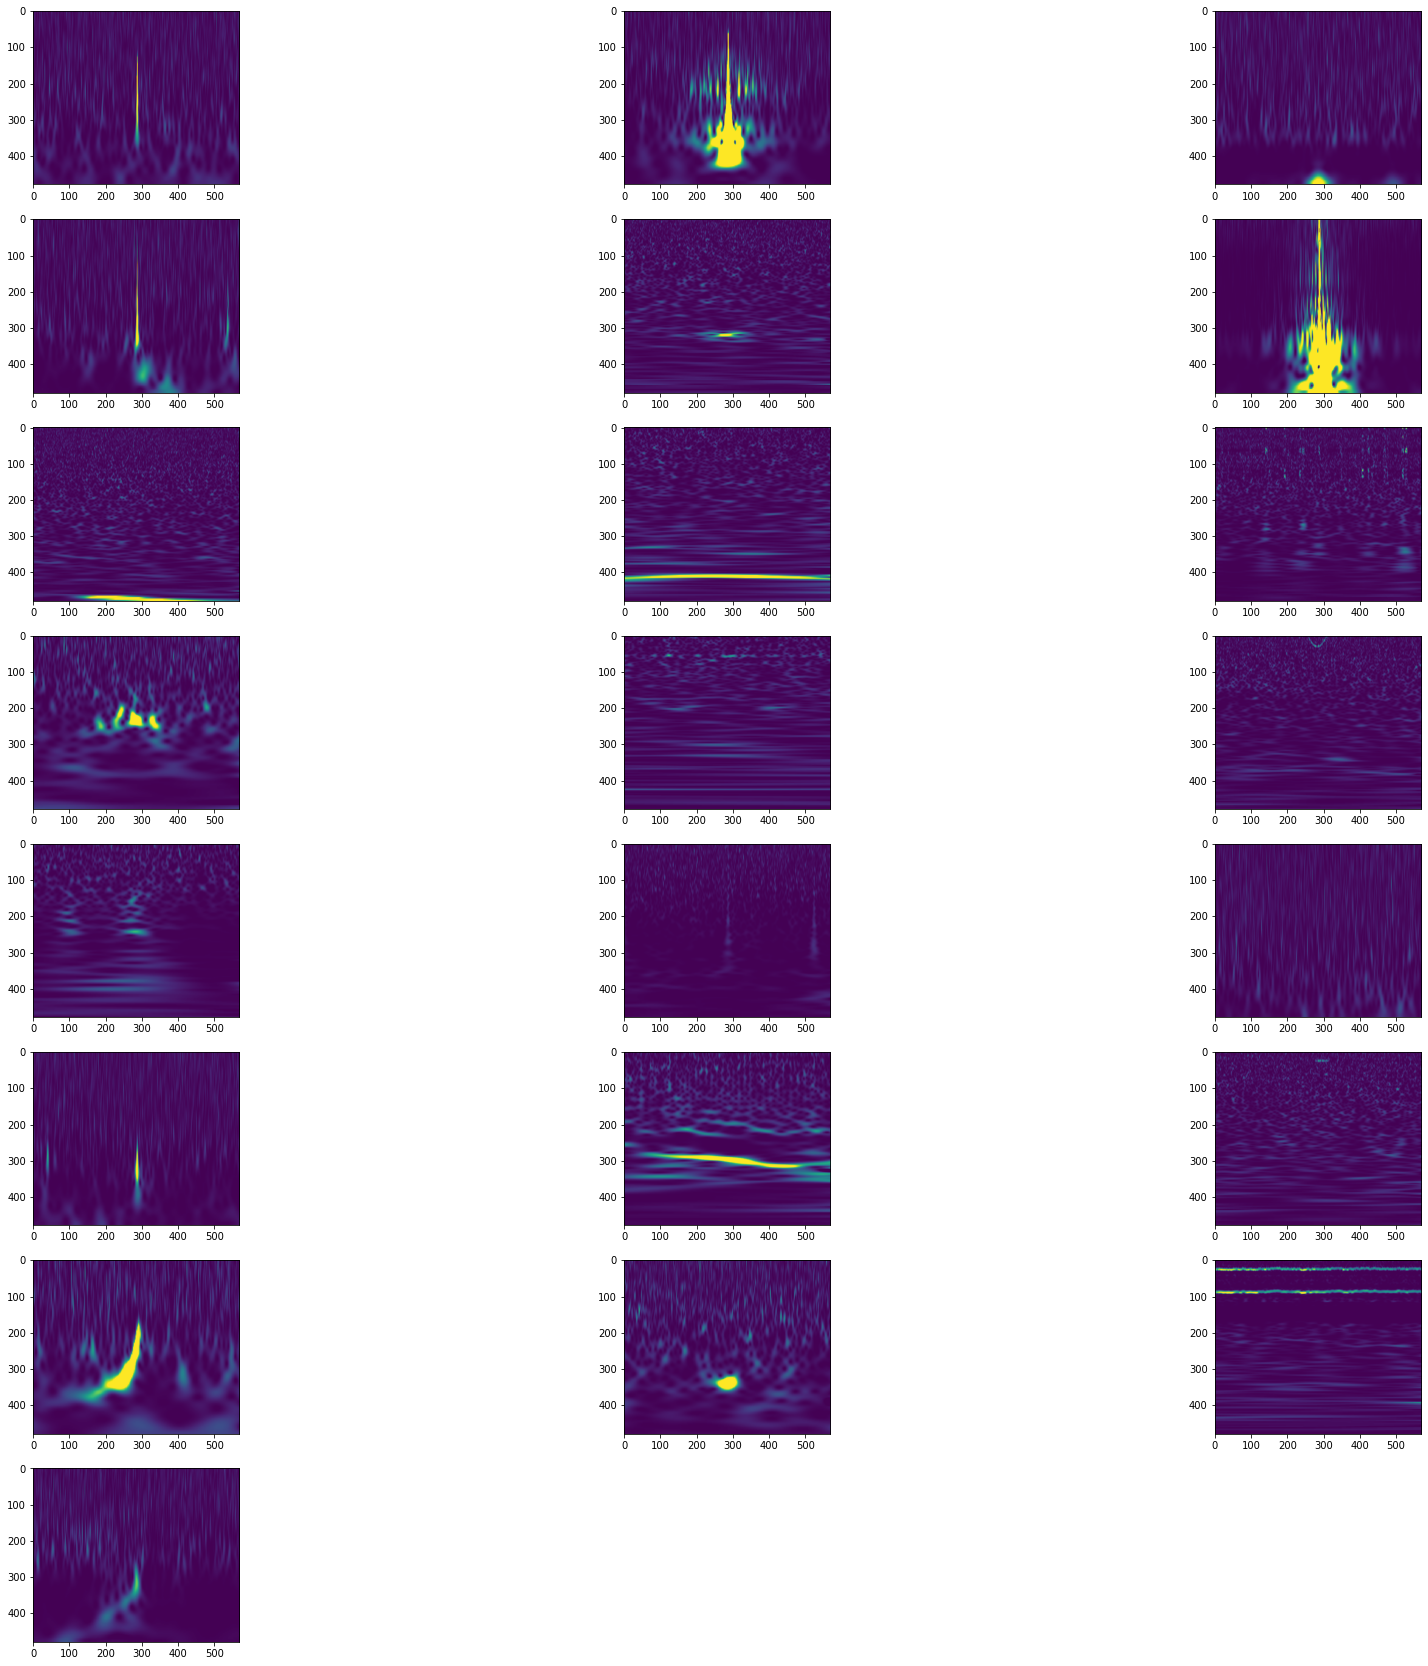

In [65]:
plt.figure(figsize=(30, 30))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + "/" + classes_list[i] + '/' + os.listdir(train_dir + "/" + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

In [66]:
training_batch_size = 10
validation_batch_size = 10
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [67]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [68]:
test_size = !find '/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


In [69]:
input_shape = (img_dim, img_dim, 3)

base_model = tf.keras.applications.DenseNet169(
    weights="imagenet",
    include_top=False,
    input_shape = input_shape
)
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

model.layers[0].trainable = False

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = [tf.keras.metrics.AUC(name='auc')]
)
model.summary()

51888128/51877672 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 1664)        0         
_________________________________________________________________
batch_normalization_409 (Bat (None, 7, 7, 1664)        6656      
_________________________________________________________________
flatten_3 (Flatten)          (None, 81536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               41746944  
_________________________________________________________________
dense_7 (Dense)              (None, 22)                11286     
Total params: 54,407,766
Trainable params: 41,761,558
N

In [70]:
training_step_size = 32
validation_step_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_auc",
    mode = "max",
    patience = 6
)
history = model.fit(
    train_generator,
    steps_per_epoch = training_step_size,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_step_size,
    callbacks = [early_stopping],
    verbose = 1,
)

print("Training Done")

Epoch 1/100
32/32 [==============================] - 54s 1s/step - loss: 9.2142 - auc: 0.7543 - val_loss: 10.2021 - val_auc: 0.7636
Epoch 2/100
32/32 [==============================] - 34s 1s/step - loss: 2.7905 - auc: 0.8869 - val_loss: 3.4029 - val_auc: 0.8862
Epoch 3/100
32/32 [==============================] - 40s 1s/step - loss: 1.8086 - auc: 0.9204 - val_loss: 2.2263 - val_auc: 0.9147
Epoch 4/100
32/32 [==============================] - 41s 1s/step - loss: 1.7262 - auc: 0.9324 - val_loss: 2.4794 - val_auc: 0.9311
Epoch 5/100
32/32 [==============================] - 39s 1s/step - loss: 2.0586 - auc: 0.9203 - val_loss: 1.0557 - val_auc: 0.9613
Epoch 6/100
32/32 [==============================] - 35s 1s/step - loss: 0.8783 - auc: 0.9652 - val_loss: 0.8852 - val_auc: 0.9695
Epoch 7/100
32/32 [==============================] - 40s 1s/step - loss: 0.8534 - auc: 0.9759 - val_loss: 0.9421 - val_auc: 0.9701
Epoch 8/100
32/32 [==============================] - 34s 1s/step - loss: 1.1893 - 

In [71]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [72]:
# test_scores = model.evaluate(test_generator, steps = test_size, verbose = 1)

In [73]:

# print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

classes = classes_list
train_hist = history
test_gen = test_generator

y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)

# Evaluate the results:
test_loss, test_metric = model.evaluate(test_gen,verbose = False)
results       = test_metric*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
print(results_title.format(results))
print(len(results_title) * "-")
    
# print classification report
print(classification_report(y_actual, y_pred, target_names=classes))


 Model AUC on Test Data:98.17599654197693%
-------------------------------------------
                     precision    recall  f1-score   support

               Blip       0.95      0.92      0.94      1092
           Koi_Fish       0.90      0.91      0.91       408
Low_Frequency_Burst       0.78      0.86      0.81       360
   Light_Modulation       0.82      0.73      0.77       312
         Power_Line       0.89      0.95      0.92       272
     Extremely_Loud       0.81      0.98      0.89       256
Low_Frequency_Lines       0.68      0.83      0.75       264
    Scattered_Light       0.97      0.85      0.91       268
        Violin_Mode       0.95      0.88      0.92       256
           Scratchy       0.92      0.95      0.94       200
          1080Lines       0.91      0.88      0.90       200
            Whistle       0.93      0.89      0.91       180
              Helix       0.92      0.85      0.88       168
    Repeating_Blips       0.66      0.81      0.73       

In [75]:
# extract data from training history for plotting
history_dict    = train_hist.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
auc_values      = history_dict['auc']
val_auc_values  = history_dict['val_auc']
epochs          = range(1, len(history_dict['auc']) + 1)

# get the min loss and max auc for plotting
max_auc = np.max(val_auc_values)
min_loss = np.min(val_loss_values)
    

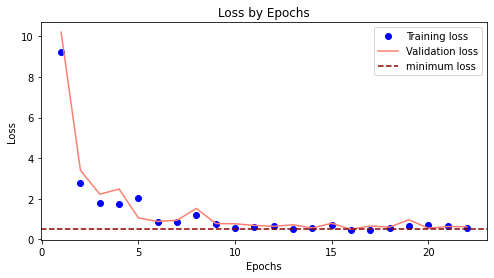

In [76]:
# create plots
plt.subplots(figsize=(8,4))

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
plt.title('Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkred', linestyle='--', label = "minimum loss")
plt.legend()

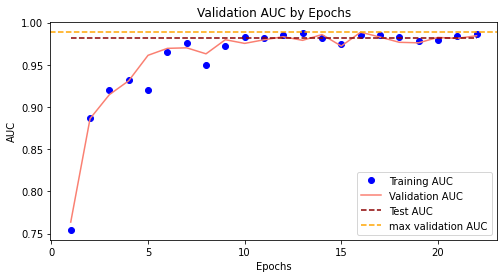

In [77]:
plt.subplots(figsize=(8,4))
plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
plt.plot(epochs, val_auc_values, 'salmon', label = 'Validation AUC')
plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test AUC')
plt.title('Validation AUC by Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.axhline(y=max_auc,color='orange', linestyle='--', label = "max validation AUC")
plt.legend()

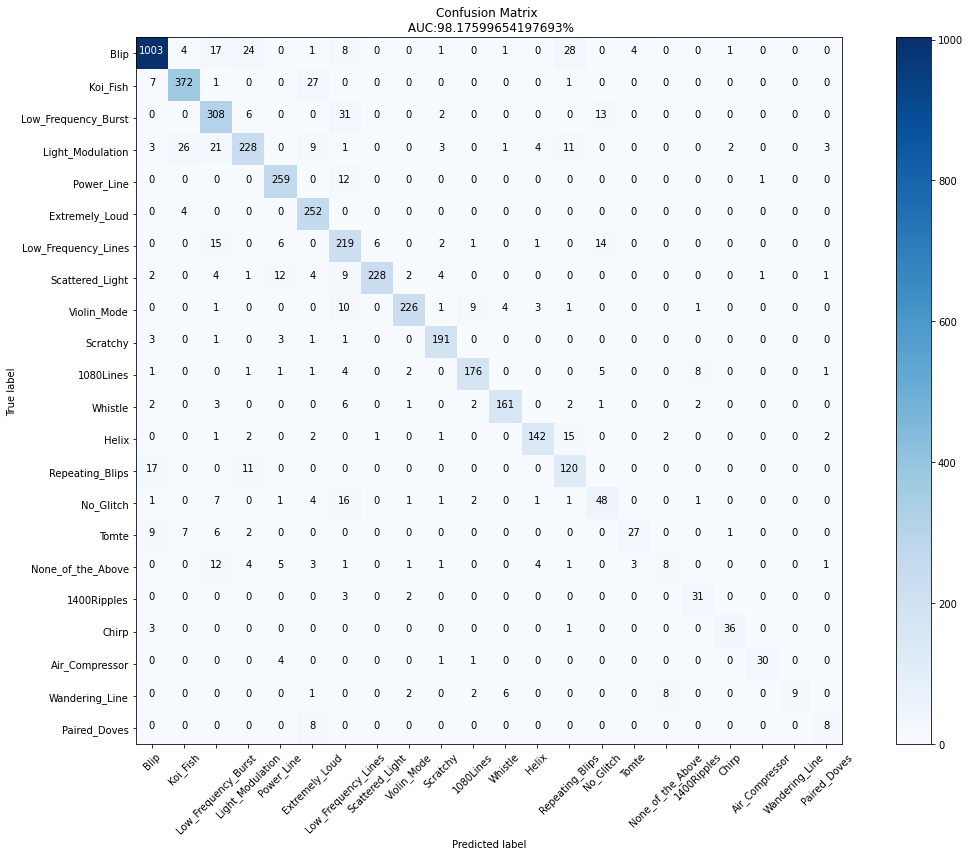

In [78]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.497911 to fit



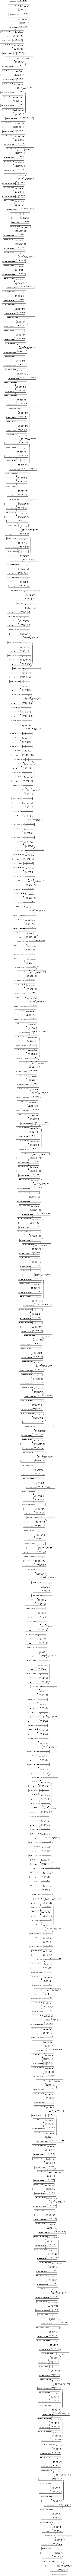

In [79]:
from keras.utils.vis_utils import plot_model

plot_model(base_model, to_file="InceptionResNetV2_Base_Model.png", show_shapes=True, show_layer_names=True)